In [1]:
%matplotlib inline

In [2]:
import pickle
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from networkx.algorithms.approximation import clique
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm

from utils import SBM_Data, load_or_calc_and_save, ytrue_to_partition, calc_avranks, RFE_custom

In [3]:
data_hub = SBM_Data()
results, results_modularity_any3, modularity_results = data_hub.load_precalculated()
X, y, X_train, y_train, X_val, y_val, feature_names = data_hub.make_dataset(results_modularity_any3)

 50%|█████     | 34/68 [00:00<00:00, 230.88it/s]

wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.001.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.002.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.005.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.007.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.010.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.020.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.030.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.050.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.10_0.001.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.10_0.002

100%|██████████| 68/68 [00:00<00:00, 297.97it/s]


wrapper: cache file ../../cache/cache/feature_importance/200_2_0.30_0.150.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/201_3_0.30_0.100.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/200_4_0.10_0.001.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/200_4_0.10_0.005.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/200_4_0.10_0.010.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/200_4_0.10_0.020.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/200_4_0.10_0.050.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/200_4_0.10_0.100.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/200_4_0.30_0.100.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/200_4_0.30_0.150

# Feature importance

In [4]:
X.shape

(170000, 43)

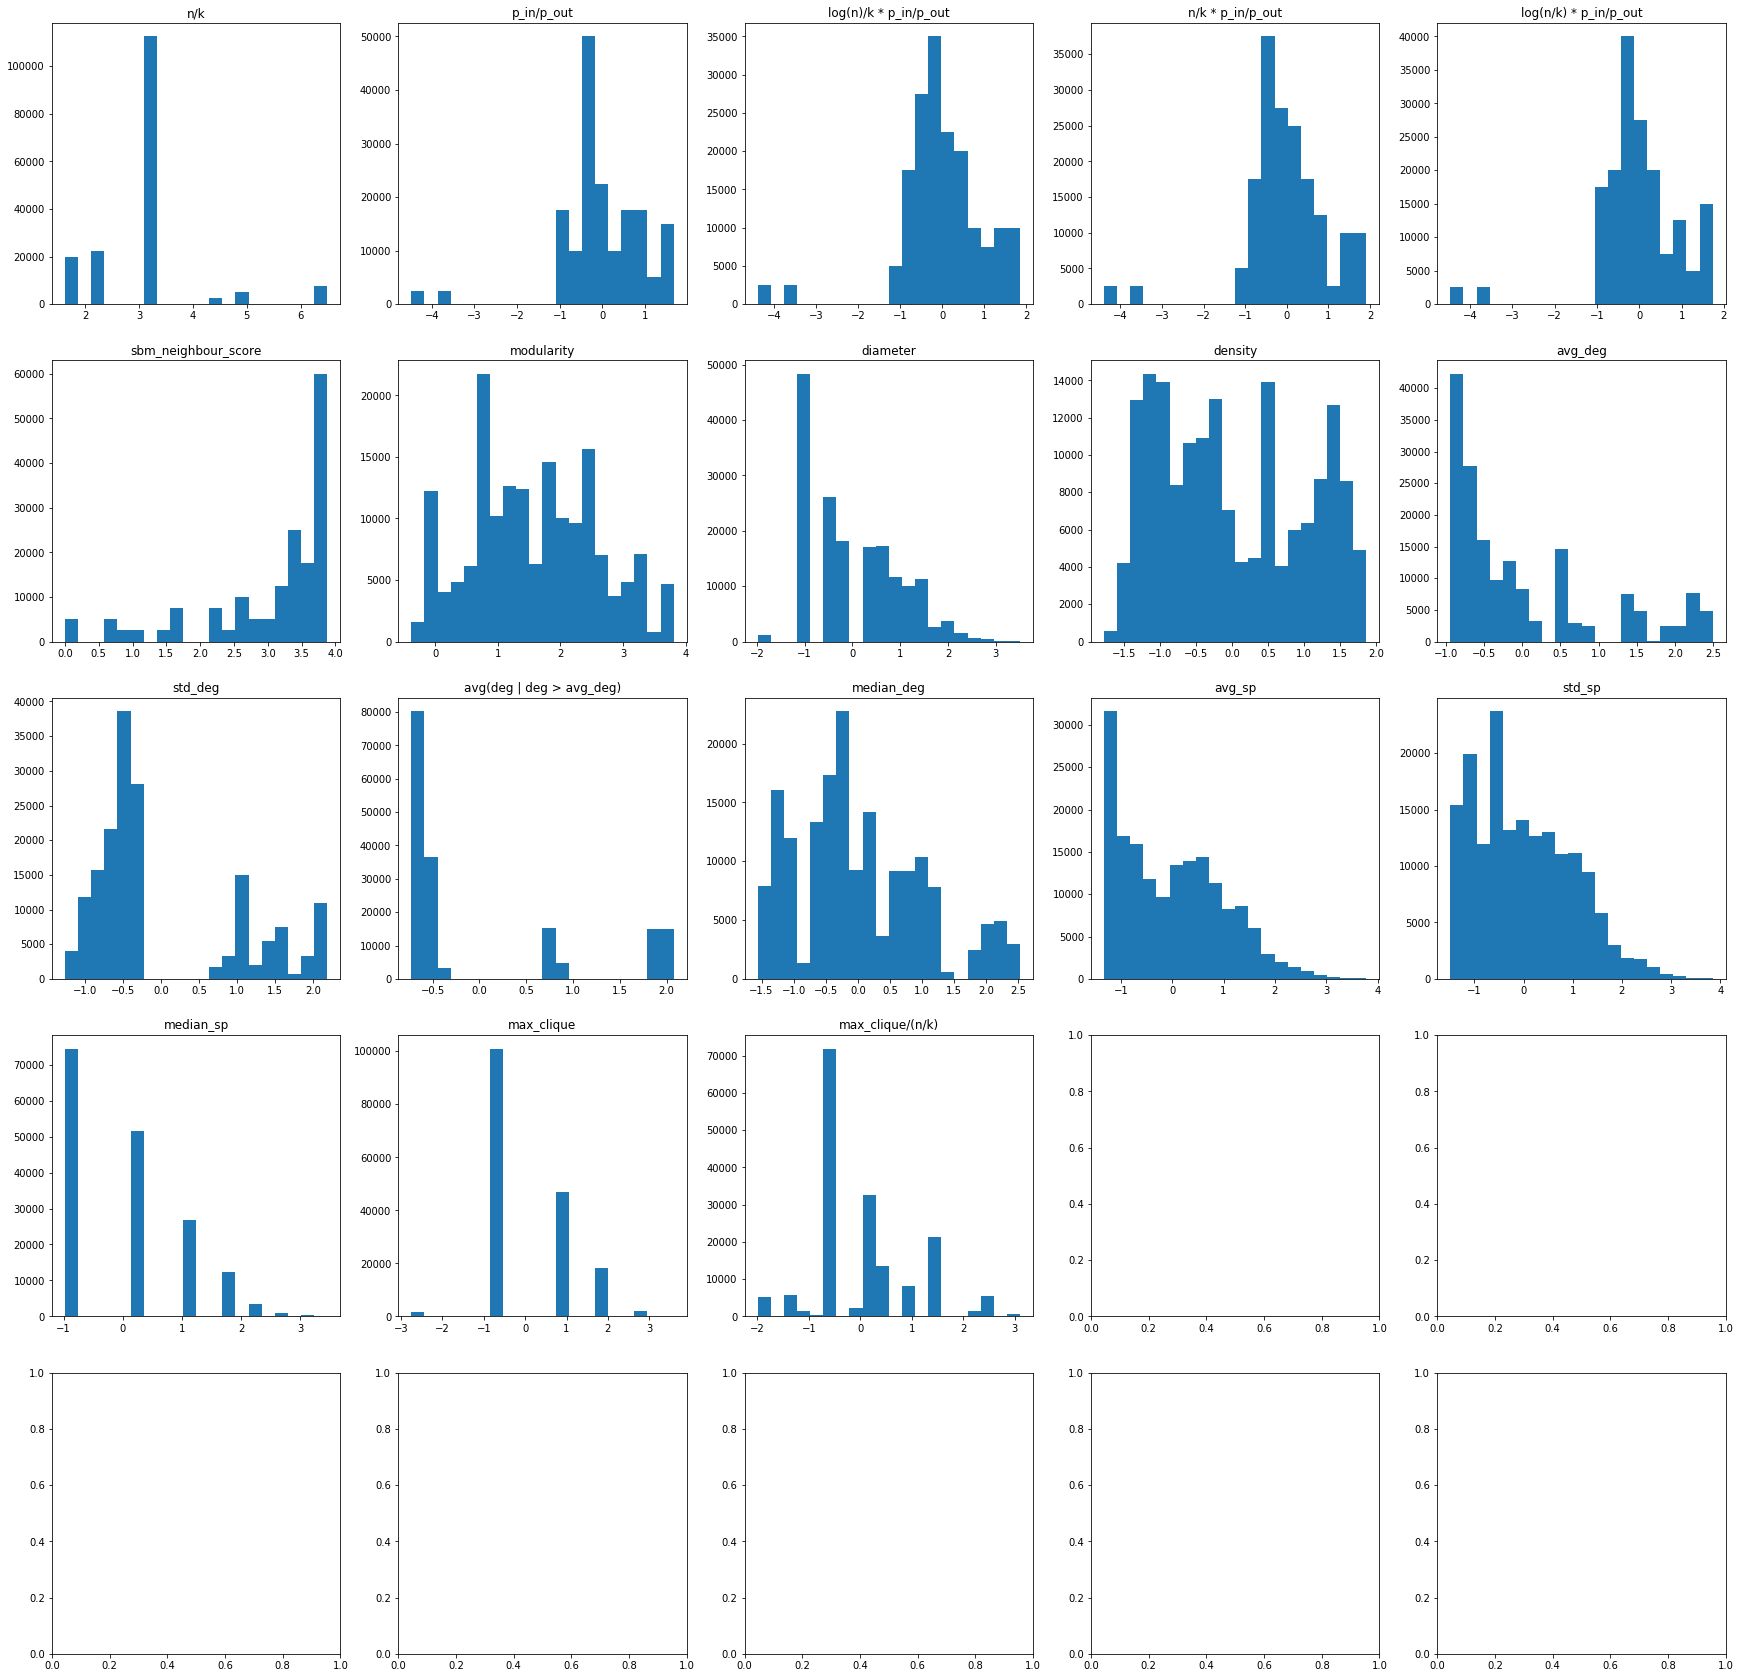

In [5]:
fig, ax = plt.subplots(5, 5, figsize=(30, 30))
ax = ax.ravel()
for i, name in enumerate(feature_names[:-25]):
    ax[i].hist(X[:, i], bins=20)
    ax[i].set_title(name)

In [6]:
estimator = LogisticRegression(max_iter=10000)
estimator.fit(X_train, y_train)
pd.DataFrame([{'feature': k, 'importance': v} for k, v in sorted(zip(feature_names, estimator.coef_[0]), key=lambda x: -np.abs(x[1]))])

,feature,importance
0,density,3.656588
1,modularity,3.062019
2,std_deg,2.518985
3,avg_deg,-2.389337
4,max_clique/(n/k),-2.036005
5,kernel_logHeat,-1.670270
6,std_sp,1.471822
7,max_clique,1.348298
8,sbm_neighbour_score,-1.306688
9,avg_sp,-1.194992


In [ ]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE_custom(estimator)  # , n_features_to_select=3, verbose=1
selector = selector.fit(X_train, y_train, X_val, y_val, feature_names)
print(list(zip(feature_names, selector.support_)))
print(list(zip(feature_names, selector.ranking_)))

  0%|          | 0/18 [00:00<?, ?it/s]

all features, acc=0.852, f1=0.740


  0%|          | 0/153 [00:00<?, ?it/s]

1 features, set=('n/k * p_in/p_out',) acc=0.758, f1=0.420


 75%|███████▌  | 115/153 [02:12<00:42,  1.11s/it]

In [ ]:
support = selector.support_.copy()
support[-25:] = 1
pd.DataFrame(zip(feature_names, support, selector.ranking_), columns=['feature', 'to choose', 'rank']).sort_values('rank')

In [ ]:
# all features
estimator = LogisticRegression(max_iter=10000)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_val)

acc = accuracy_score(y_val.ravel(), y_pred.ravel())
f1 = f1_score(y_val.ravel(), y_pred.ravel())
                     
print(f'acc: {acc:.2f}')
print(f'f1: {f1:.2f}')

In [ ]:
# top
estimator = LogisticRegression(max_iter=10000)
estimator.fit(X_train[:, support], y_train)
y_pred = estimator.predict(X_val[:, support])

acc = accuracy_score(y_val.ravel(), y_pred.ravel())
f1 = f1_score(y_val.ravel(), y_pred.ravel())
                     
print(f'acc: {acc:.2f}')
print(f'f1: {f1:.2f}')